In [18]:
import numpy as np
import matplotlib.pyplot as plt
# import scienceplots
from mpl_toolkits.mplot3d import Axes3D
# plt.style.use(["science", "no-latex"])

from pydrake import symbolic
from pydrake.all import LeafSystem
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput


In [19]:
# Spacecraft Parameters

# Inertial properties
J = np.diag([100, 200, 300]) # kg*m^2
Jinv = np.linalg.inv(J)

# Torque limits
tau_max = np.array([10, 10, 10]) # N*m

# Initial state vector
x0 = np.array([0, 0, 0, 0.5, 0.5, 0.5, 0.5]) # [w_x, w_y, w_z, q_w, q_x, q_y, q_z]
# Final state vector
xn = np.array([0, 0, 0, 0.0258, 0.0258, 0.0258, 0.999]) # [w_x, w_y, w_z, q_w, q_x, q_y, q_z]

# Camera vector
c = np.array([0, 0, 1]) # Boresight along z
# Sun vector
s = np.array([0.75, 0.433, 0.5])

In [20]:
# Helper functions
def qdot_matrix(q):
    qw, qx, qy, qz = q
    return np.array([
        [-qx, -qy, -qz],
        [qw, -qz, qy],
        [qz, qw, -qx],
        [-qy, qx, qw]
    ])

def euler_eqn(w, u):
    return Jinv @ (u - np.cross(w, J @ w))

def qdot(q, w):
    return 0.5 * qdot_matrix(q) @ w

def qspace(q):
    return np.array([q[4]/q[3], q[5]/q[3], q[6]/q[3]])

In [21]:
# x = [wx, wy, wz, qw, qx, qy, qz]
def satellite_continuous_dynamics(x, u):
    w = x[:3]
    q = x[3:]

    w_dot = euler_eqn(w, u)
    q_dot = qdot(q, w)

    return np.concatenate([w_dot, q_dot])

# Implicit Euler integration for use with solver
def satellite_discrete_dynamics(x, x_next, u, time_step):
    x_dot = satellite_continuous_dynamics(x_next, u)
    residuals = x_next - x - time_step * x_dot
    
    return residuals

In [22]:
# Not actually needed for optimizer
class SpacecraftDynamics(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        # Declare states
        state_index = self.DeclareContinuousState(7) # 7 states
        self.DeclareStateOutputPort("y", state_index) # 7 outputs
        self.DeclareVectorInputPort("u", 3)  # 3 inputs
    
    def DoCalcTimeDerivatives(self, context, derivatives):
        # Extract the state
        x = context.get_continuous_state_vector().CopyToVector()
        # Extract the input
        u = self.EvalVectorInput(context, 0).CopyToVector()
        # Compute the time derivative
        xdot = self.dynamics(x, u)

        # Set the time derivative of the state
        derivatives.get_mutable_vector().SetFromVector(xdot)

    def dynamics(self, x, u):
        # Define the dynamics of the system
        # xdot = f(x, u)
       
        xdot = satellite_continuous_dynamics(x, u)
        # print(xdot)

        return xdot
    
continuous_system = SpacecraftDynamics()

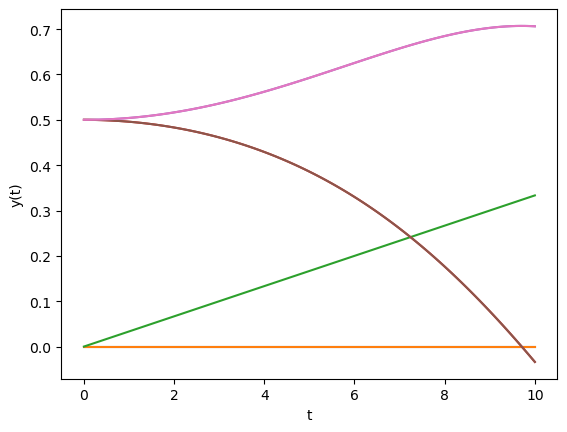

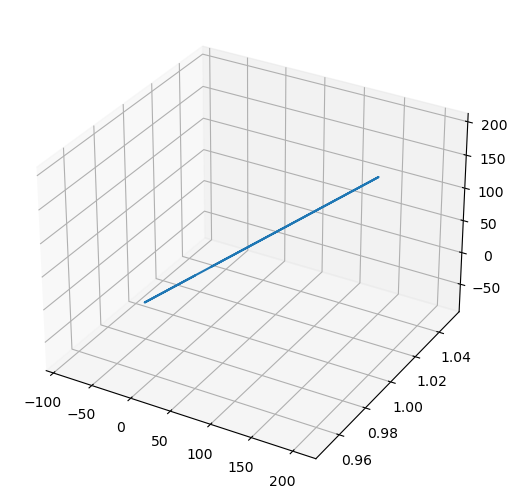

In [29]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(SpacecraftDynamics())
builder.ExportInput(system.get_input_port())

logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState(x0)

diagram.get_input_port(0).FixValue(context, [0, 0, 10])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()

# Calculate q space
qspace_vec = [qspace(x) for x in log.data().transpose()]

x = [point[0] for point in qspace_vec]
y = [point[1] for point in qspace_vec]
z = [point[2] for point in qspace_vec]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
plt.plot(x, y, z)
plt.show()

88747


In [ ]:
# Here Brandon will write the function that takes in trajectories over state and outputs a 3D animation

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import quaternion

# Function to rotate a point using a quaternion
def rotate_point(point, quaternion):
    # Convert the point to a quaternion
    p = np.quaternion(0, *point)
    # Rotate the point using the quaternion
    rotated_point = quaternion * p * quaternion.conjugate()
    # Extract the rotated coordinates
    return [rotated_point.x, rotated_point.y, rotated_point.z]

# Sample 3D model data (a cube)
vertices = np.array([[1, 1, 1],
                     [1, 1, -1],
                     [1, -1, -1],
                     [1, -1, 1],
                     [-1, 1, 1],
                     [-1, 1, -1],
                     [-1, -1, -1],
                     [-1, -1, 1]])

# Create some sample rotation quaternions (random for demonstration)
num_frames = 100
rotation_quaternions = [quaternion.from_rotation_vector(np.random.uniform(size=3)) for _ in range(num_frames)]

# Function to update the plot for each frame of the animation
def update(frame):
    ax.clear()

    # Rotate each vertex of the 3D model using the corresponding quaternion for this frame
    rotated_vertices = np.array([rotate_point(vertex, rotation_quaternions[frame]) for vertex in vertices])

    # Plot the rotated 3D model
    ax.scatter(rotated_vertices[:,0], rotated_vertices[:,1], rotated_vertices[:,2], color='red', label='Rotated')
    for i in range(8):
        ax.text(rotated_vertices[i,0], rotated_vertices[i,1], rotated_vertices[i,2], '%s' % (str(i)), size=10, zorder=1, color='k')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Model Rotation')

# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set initial plot settings
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, interval=50, repeat=True)

plt.show()


: 